In [3]:
import os
import math  
import pickle
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from pathlib import Path
import sys
from sklearn.metrics import roc_curve, auc
import re

sys.path.append('/home/scarlett/github/Ipy_notebook')
from Python.quickBeast import predict_BEASTIE_GAM_lambda, get_tsv_p_values, get_ROC_tsv #ROC_comparison_fix3_qb
from Python.ROC_common import Make_judgement
from Python.ROC_noLAMBDA import Prepare_data_fix, Prepare_data_fix_semi, get_ROC_AUC
BEASTIE_path="/home/scarlett/github/BEASTIE"
sys.path.append(str(BEASTIE_path))
from BEASTIE import predict_lambda_GAM
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t
from prettytable import PrettyTable
from statsmodels.stats.multitest import multipletests
from sstudentt import SST

In [18]:
# pip install rpy2

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.3/219.3 KB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Traceback (most recent call last):
        File "/usr/lib/python3/dist-packages/pip/_vendor/pep517/in_process/_in_process.py", line 363, in <module>
          main()
        File "/usr/lib/python3/dist-packages/pip/_vendor/pep517/in_process/_in_process.py", line 345, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "/usr/lib/python3/dist-packages/pip/_vendor/pep517/in_process/_in_process.py", line 130, in get_requires_for_build_wheel
          return hook(config_settings)
        File "/usr/lib/python3/dist-packages/setuptools/build_meta.py", line 162, 

In [19]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

ModuleNotFoundError: No module named 'rpy2'

**Power curve across different models<br>1. testing case<br>2. parametrized simulator<br>3. semi empirical simulator**

#### checking the p-values from qb output

In [4]:

def get_data(n_gene,n_hets,n_depth,alt,sigma=0.7):
    NEG=f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-1_s-{sigma}.pickle"
    POS=f"g-{n_gene}_h-{n_hets}_d-{n_depth}_t-{alt}_s-{sigma}.pickle"
    ns_NEG,ns_POS,qb_NEG,qb_POS = get_filename(POS,NEG)
    path_beastie = "/data2/stan/iBEASTIE4/sigma0.7/parametrized/ASE_0.05_error/output_pkl/"
    path_qb=f"/data2/stan/quickBEAST/a8.789625_b8.789625/lambda0.04545/parametrized/ASE_0.05_error/"
    NS_path="/data2/stan/binomial/parametrized/ASE_0.05_error/NS_p"
    qb_POS, qb_NEG = get_qb_output(qb_POS, qb_NEG, path_qb)
    qb_POS_p, qb_NEG_p,_,_ = get_qb_p_values(qb_POS, qb_NEG)
    b_pos, b_neg = get_BEASTIE_tsv(NEG,POS,path_beastie)
    b_pos_p, b_neg_p = get_BEASTIE_pval(b_pos, b_neg)
    ns_POS_p, ns_NEG_p = get_NS_p_values(ns_POS, ns_NEG, NS_path)
    return qb_POS_p, qb_NEG_p,b_pos_p, b_neg_p,ns_POS_p, ns_NEG_p, qb_POS, qb_NEG, b_pos, b_neg

def get_qb_output(qb_POS, qb_NEG, qb_path):
    qb_pos_file=pd.read_csv(f"{qb_path}/{qb_POS}",delimiter="\t",header=0)
    qb_neg_file=pd.read_csv(f"{qb_path}/{qb_NEG}",delimiter="\t",header=0)
    return qb_pos_file,qb_neg_file

def get_qb_p_values(qb_pos_file,qb_neg_file):
    qb_pos_p_t = qb_pos_file['t_p_value'].tolist()
    qb_neg_p_t = qb_neg_file['t_p_value'].tolist()
    qb_pos_p_n = qb_pos_file['normal_p_value'].tolist()
    qb_neg_p_n = qb_neg_file['normal_p_value'].tolist()
    return qb_pos_p_t,qb_neg_p_t,qb_pos_p_n,qb_neg_p_n

def get_BEASTIE_tsv(NEG,POS,path_beastie):
    NEG = NEG.replace('.pickle', '.tsv')
    POS = POS.replace('.pickle', '.tsv')
    NEG = pd.read_csv(path_beastie+NEG,sep="\t")
    POS = pd.read_csv(path_beastie+POS,sep="\t")
    return POS, NEG

def get_BEASTIE_pval(NEG,POS):
    NEG_pval = NEG["t_p_value"].values
    POS_pval = POS["t_p_value"].values
    return POS_pval,NEG_pval

def get_filename(b_POS,b_NEG):  
    ns_NEG = re.sub(r'_s-\d+(\.\d+)?', '', b_NEG)
    ns_POS = re.sub(r'_s-\d+(\.\d+)?', '', b_POS)
    qb_NEG = re.sub(r'_s-\d+(\.\d+)?', '', b_NEG).replace('.pickle', '.txt')
    qb_POS = re.sub(r'_s-\d+(\.\d+)?', '', b_POS).replace('.pickle', '.txt')
    return ns_NEG,ns_POS,qb_NEG,qb_POS

def qq_norm(data):
    # Without fit=True: The sample quantiles are plotted against the theoretical quantiles of a standard normal distribution.
    # With fit=True: The sample data's mean and standard deviation are used to standardize both the sample data and the theoretical quantiles of the standard normal distribution before plotting them against each other.
    data_array = np.array(data)
    sm.qqplot(data_array, line='45', fit=True)
    plt.title('QQ plot against normal distribution')
    plt.show()

def qq_skewed_t(data):
    # Convert data to numpy array
    data_array = np.array(data)
    # Fit data to a t-distribution to get the parameters
    df, loc, scale = t.fit(data_array)
    # Calculate the theoretical quantiles for the t-distribution
    theoretical_quantiles = t.ppf(np.linspace(0, 1, len(data_array)), df, loc, scale)
    
    # Sort data
    sorted_data = np.sort(data_array)
    # Get the min and max values across both datasets for the y=x line
    min_val = min(min(sorted_data), min(theoretical_quantiles))
    max_val = max(max(sorted_data), max(theoretical_quantiles))
    # Plot
    plt.plot(theoretical_quantiles,sorted_data, 'o')
    plt.plot([min(sorted_data), max(sorted_data)],
            [min(sorted_data), max(sorted_data)], 'r-')  # line of equality
    plt.ylabel('Observed Data')
    plt.xlabel('Theoretical Quantiles (t-distribution)')
    plt.title('QQ plot against t-distribution')
    plt.show()

def get_corrected_p(qb_POS_p,qb_NEG_p):
    # Apply FDR correction
    _, qb_POS_p_fdr, _, _ = multipletests(qb_POS_p, method='fdr_bh')
    _, qb_NEG_p_fdr, _, _ = multipletests(qb_NEG_p, method='fdr_bh')

    # Apply Bonferroni correction
    _, qb_POS_p_bonf, _, _ = multipletests(qb_POS_p, method='bonferroni')
    _, qb_NEG_p_bonf, _, _ = multipletests(qb_NEG_p, method='bonferroni')
    return qb_POS_p_fdr, qb_NEG_p_fdr, qb_POS_p_bonf, qb_NEG_p_bonf


In [6]:
GIAB_file_path = "/data2/NA12878/beastie/runModel_phased_even101/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/iBEASTIE3"

In [8]:
qb = pd.read_csv(GIAB_file_path+"/qb.tsv", sep='\t')
qb

,geneID,qb_mean,qb_var,qb_mode,qb_zscore,normal_p_value,t_p_value,st_p_value
0,ENSG00000187583,0.517122,0.010028,0.519602,0.519602,0.704552,0.704551,0.706339
1,ENSG00000188290,0.566433,0.010440,0.572907,0.572907,0.156849,0.156849,0.150492
2,ENSG00000187608,0.517958,0.000102,0.518002,0.518002,0.044424,0.046555,0.040445
3,ENSG00000188157,0.448559,0.000433,0.446095,0.446095,0.000407,0.002451,0.000641
4,ENSG00000237330,0.481595,0.012107,0.477598,0.477598,0.582188,0.582189,0.582519
...,...,...,...,...,...,...,...,...
7631,ENSG00000198113,0.525133,0.001338,0.525903,0.525903,0.475619,0.453654,0.477988
7632,ENSG00000187609,0.555929,0.003908,0.557806,0.557806,0.325395,0.325393,0.324328
7633,ENSG00000165802,0.601217,0.006763,0.607511,0.607511,0.077062,0.077062,0.068545
7634,ENSG00000197070,0.449680,0.001597,0.448095,0.448095,0.208317,0.208317,0.210036


In [28]:
beastie = pd.read_csv(GIAB_file_path+"/NA12878_ASE_sub.tsv", sep='\t')
beastie = beastie[["geneID","number.of.hets","NaiveSum_pval","MajorSite_pval"]]
beastie['geneID'] = beastie['geneID'].str.split('.').str[0]
beastie

,geneID,number.of.hets,NaiveSum_pval,MajorSite_pval
0,ENSG00000000460,2,0.125000,0.500000
1,ENSG00000001036,5,0.048647,0.003042
2,ENSG00000001084,3,0.803619,1.000000
3,ENSG00000001460,1,1.000000,1.000000
4,ENSG00000001461,1,0.804317,0.804317
...,...,...,...,...
7631,ENSG00000272647,1,1.000000,1.000000
7632,ENSG00000272734,3,0.515426,0.855536
7633,ENSG00000273311,4,0.168638,0.387695
7634,ENSG00000273319,3,0.687500,0.500000


In [44]:
result_df = pd.merge(qb, beastie, on='geneID', how='inner')  # For a left join
result_df = pd.merge(result_df, annotation, on='geneID', how='inner')
result_df


,geneID,qb_mean,qb_var,qb_mode,qb_zscore,normal_p_value,t_p_value,st_p_value,number.of.hets,NaiveSum_pval,MajorSite_pval,Gene.name
0,ENSG00000187583,0.517122,0.010028,0.519602,0.519602,0.704552,0.704551,0.706339,2,1.000000,0.625000,PLEKHN1
1,ENSG00000188290,0.566433,0.010440,0.572907,0.572907,0.156849,0.156849,0.150492,1,0.375000,0.375000,HES4
2,ENSG00000187608,0.517958,0.000102,0.518002,0.518002,0.044424,0.046555,0.040445,1,0.042428,0.042428,ISG15
3,ENSG00000188157,0.448559,0.000433,0.446095,0.446095,0.000407,0.002451,0.000641,9,0.000035,0.054509,AGRN
4,ENSG00000237330,0.481595,0.012107,0.477598,0.477598,0.582188,0.582189,0.582519,2,1.000000,0.500000,RNF223
...,...,...,...,...,...,...,...,...,...,...,...,...
7596,ENSG00000198113,0.525133,0.001338,0.525903,0.525903,0.475619,0.453654,0.477988,2,0.497629,1.000000,TOR4A
7597,ENSG00000187609,0.555929,0.003908,0.557806,0.557806,0.325395,0.325393,0.324328,1,0.371298,0.371298,EXD3
7598,ENSG00000165802,0.601217,0.006763,0.607511,0.607511,0.077062,0.077062,0.068545,1,0.143463,0.143463,NSMF
7599,ENSG00000197070,0.449680,0.001597,0.448095,0.448095,0.208317,0.208317,0.210036,2,0.186765,0.505236,ARRDC1


In [35]:
import pandas as pd
from statsmodels.stats.multitest import multipletests

def calculate_fdr_and_threshold(df, threshold=0.05):
    # Apply FDR correction
    df['qb_adj'] = multipletests(df['st_p_value'], method='fdr_bh')[1]
    df['ns_adj'] = multipletests(df['NaiveSum_pval'], method='fdr_bh')[1]
    df['ms_adj'] = multipletests(df['MajorSite_pval'], method='fdr_bh')[1]
    
    # Calculate the percentage below the threshold for each adjusted p-value
    p1_below_threshold = (df['qb_adj'] < threshold).sum() 
    p2_below_threshold = (df['ns_adj'] < threshold).sum() 
    p3_below_threshold = (df['ms_adj'] < threshold).sum() 
    
    # Create a summary table
    summary_table = pd.DataFrame({
        'P-Value': ['qb', 'ns', 'ms'],
        'Count Below 0.05': [p1_below_threshold, p2_below_threshold, p3_below_threshold]
    })
    
    return summary_table

import pandas as pd
from statsmodels.stats.multitest import multipletests

def calculate_percentage_per_group(df, threshold=0.05):
    # Apply FDR correction
    df['qb_adj'] = multipletests(df['st_p_value'], method='fdr_bh')[1]
    df['ns_adj'] = multipletests(df['NaiveSum_pval'], method='fdr_bh')[1]
    df['ms_adj'] = multipletests(df['MajorSite_pval'], method='fdr_bh')[1]
    
    # Initialize a dictionary to store results
    percentage_dict = {'number.of.hets': [], 'qb_count': [], 'ns_count': [], 'ms_count': []}
    
    # Calculate the percentage for each method per each unique value in "number.of.hets"
    for value in df['number.of.hets'].unique():
        sub_df = df[df['number.of.hets'] == value]
        p1_percentage = (sub_df['qb_adj'] < threshold).sum() 
        p2_percentage = (sub_df['ns_adj'] < threshold).sum() 
        p3_percentage = (sub_df['ms_adj'] < threshold).sum() 

        percentage_dict['number.of.hets'].append(value)
        percentage_dict['qb_count'].append(p1_percentage)
        percentage_dict['ns_count'].append(p2_percentage)
        percentage_dict['ms_count'].append(p3_percentage)
    
    # Convert the dictionary to a DataFrame
    percentage_df = pd.DataFrame(percentage_dict)
    percentage_df.sort_values('number.of.hets', inplace=True)
    
    return percentage_df

# Example usage:
# Assuming 'df' is your DataFrame with the p-values columns named 'p1', 'p2', 'p3', and the 'number.of.hets' column
# percentage_df = calculate_percentage_per_group(df)
# print(percentage_df)


In [36]:
calculate_percentage_per_group(result_df, threshold=0.05)

,number.of.hets,qb_count,ns_count,ms_count
1,1,153,139,127
0,2,182,151,115
6,3,147,111,80
4,4,134,107,70
11,5,94,81,50
3,6,50,50,26
12,7,65,57,35
5,8,34,30,15
2,9,45,34,20
9,10,17,15,12


In [37]:
# Replace with the actual DataFrame variable name that contains your p-value columns
summary = calculate_fdr_and_threshold(result_df)
print(summary)


  P-Value  Count Below 0.05
0      qb              1003
1      ns               847
2      ms               579


In [54]:
import pandas as pd
from statsmodels.stats.multitest import multipletests

def summarize_ase_genes(df, gene_ids, title, threshold=0.05):
    # Filter the DataFrame for the interested genes
    filtered_df = df[df['Gene.name'].isin(gene_ids)]
    
    # Apply FDR correction
    qb_adj = multipletests(filtered_df['st_p_value'], method='fdr_bh')[1]
    ns_adj = multipletests(filtered_df['NaiveSum_pval'], method='fdr_bh')[1]
    ms_adj = multipletests(filtered_df['MajorSite_pval'], method='fdr_bh')[1]
    
    # Calculate the count and percentage of genes below the threshold for each method
    summary = {
        'Method': ['qb', 'ns', 'ms'],
        'Count': [
            (qb_adj < threshold).sum(),
            (ns_adj < threshold).sum(),
            (ms_adj < threshold).sum()
        ]
    }
    
    # Calculate percentages
    summary['Percentage'] = [count / len(gene_ids) * 100 for count in summary['Count']]
    
    # Create DataFrame
    summary_df = pd.DataFrame(summary)
    
    # Print title
    print(title)
    
    return summary_df

# Example usage:
# Assuming 'df' is your DataFrame with the p-values columns named 'p1', 'p2', 'p3', and 'geneID'
# gene_list = ['geneID1', 'geneID2', 'geneID3']  # Replace with your list of gene IDs
# summary_table = summarize_ase_genes(df, gene_list, 'My Summary Table Title')
# print(summary_table)

def get_gene_annotation(path):
    conversion_annotation = pd.read_csv(path + "ensemble_HGNC.txt", sep="\t", header=0)
    conversion_annotation.columns = ["geneID", "Gene.name"]
    conversion_annotation2 = pd.read_csv(
        path + "manual_annotation_geneID.txt", sep=" ", header=0
    )
    conversion_annotation2["geneID"] = (
        conversion_annotation2["geneID"].str.split(".").str[0]
    )
    annotation = pd.concat([conversion_annotation, conversion_annotation2])
    annotation_uniq = annotation.dropna()
    annotation_uniq = annotation_uniq.groupby("geneID").first().reset_index()
    return annotation_uniq


In [55]:
geneset_path="/data2/gene_sets/"
annotation = get_gene_annotation(geneset_path)
annotation

,geneID,Gene.name
0,ENSG00000000003,TSPAN6
1,ENSG00000000005,TNMD
2,ENSG00000000419,DPM1
3,ENSG00000000457,SCYL3
4,ENSG00000000460,C1orf112
...,...,...
67166,ENSG00000288695,AC064824.1
67167,ENSG00000288696,AL136225.2
67168,ENSG00000288697,AC004636.1
67169,ENSG00000288698,AC007687.1


In [56]:
reference_genelist=["GAPDH","ACT8","18SRNA","PPIA","RPL13A","TBP","SDHA","HPRT1","GUSB","AHSP","HBS1L"]
haploinsufficient_genelist=["P53","DMP1","NF1","PTEN"]
imprinted_genelist=["SNRPN","PEG10"]

In [57]:
summarize_ase_genes(result_df, reference_genelist, "reference genes", threshold=0.05)

reference genes


,Method,Count,Percentage
0,qb,2,18.181818
1,ns,1,9.090909
2,ms,2,18.181818


In [58]:
summarize_ase_genes(result_df, haploinsufficient_genelist, "haploinsufficient genes", threshold=0.05)

haploinsufficient genes


,Method,Count,Percentage
0,qb,0,0.0
1,ns,0,0.0
2,ms,0,0.0


In [59]:
summarize_ase_genes(result_df, haploinsufficient_genelist, "imprinted genes", threshold=0.05)

imprinted genes


,Method,Count,Percentage
0,qb,0,0.0
1,ns,0,0.0
2,ms,0,0.0


### 1. GET Z-SCORES FROM QB, BEASTIE

In [3]:
n_gene=1000
n_hets=3
n_depth=30
alt=0.5
sigma=0.7
_,_,_,_,_,_, qb_POS, qb_NEG, b_pos, b_neg = get_data(n_gene,n_hets,n_depth,alt,sigma=0.7)

In [4]:
qb_POS

,geneID,qb_posterior,qb_lambda,qb_mean,qb_var,qb_zscore,normal_p_value,t_p_value,st_p_value
0,gene1,0.995127,0.04545,0.702675,0.042775,3.397500,0.000171,0.001313,0.000005
1,gene2,0.976092,0.04545,-0.576427,0.042238,-2.804750,0.002277,0.005230,0.007451
2,gene3,0.976008,0.04545,-0.575863,0.042233,-2.802180,0.002299,0.005261,0.007500
3,gene4,0.976222,0.04545,-0.577225,0.041666,-2.827830,0.002092,0.004957,0.007026
4,gene5,0.523040,0.04545,-0.153678,0.057377,-0.641564,0.498836,0.461759,0.473843
...,...,...,...,...,...,...,...,...,...
995,gene996,0.976238,0.04545,-0.577522,0.041365,-2.839560,0.002004,0.004823,0.006818
996,gene997,0.999663,0.04545,-0.877986,0.045259,-4.127010,0.000007,0.000262,0.000155
997,gene998,0.991452,0.04545,-0.660699,0.042023,-3.223020,0.000447,0.001986,0.002447
998,gene999,0.999299,0.04545,-0.833047,0.044607,-3.944280,0.000017,0.000390,0.000281


In [5]:
b_pos

,geneID,log2_posterior_mean,log2_posterior_variance,BEASTIE_zscore,normal_p_value,t_p_value,st_p_value
0,gene1,1.010449,0.090766,3.353927,1.923366e-05,0.000206,9.397675e-06
1,gene2,-0.825968,0.082111,-2.882457,4.798386e-04,0.001093,7.560881e-04
2,gene3,-0.813524,0.102744,-2.538004,2.853091e-03,0.004472,2.594501e-03
3,gene4,-0.845626,0.088313,-2.845549,3.126981e-04,0.001043,2.236929e-04
4,gene5,-0.291869,0.165390,-0.717684,3.784660e-01,0.368249,3.763973e-01
...,...,...,...,...,...,...,...
995,gene996,-0.822343,0.081568,-2.879333,4.866513e-04,0.001104,7.657023e-04
996,gene997,-1.251045,0.096485,-4.027563,1.099521e-06,0.000021,3.594439e-06
997,gene998,-0.961742,0.095467,-3.112660,8.082387e-05,0.000442,5.270122e-05
998,gene999,-1.180578,0.085610,-4.034905,3.275476e-07,0.000023,1.393421e-07


In [6]:
b_pos["BEASTIE_zscore"].values

array([ 3.35392709, -2.8824567 , -2.53800443, -2.84554945, -0.71768398,
       -3.85070036, -2.73295638, -2.91597531, -3.66939036, -0.24922057,
       -2.91094702, -3.67285776, -3.48347639, -3.74061509, -2.4979613 ,
       -3.07254924, -2.34788217,  1.93840764, -0.97831198, -2.4933886 ,
       -1.91428062, -2.77894845, -2.34690583, -2.5365709 , -1.92415194,
       -4.15613971, -4.92931771, -3.84890802, -3.94919557, -1.98955084,
       -1.22663251, -1.12050161, -0.84533685, -3.61483666, -5.34410156,
       -3.39576667, -3.473056  , -2.28443667, -2.78626419, -3.02766106,
       -1.95030322, -2.47398104, -1.26291956, -1.16496153, -2.05602145,
       -2.09715193, -2.54272942, -2.30558886, -0.39062766, -2.21215658,
       -2.2780344 , -2.65913579, -2.4628608 , -2.77982004, -2.98062487,
       -0.79399195, -2.45937914, -3.77380383, -2.71430453, -2.0878162 ,
       -0.63965772, -1.08566333, -2.59232468, -3.44531912, -3.14227745,
       -1.68192247, -3.84579759, -2.09108132, -2.93463214, -2.91

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Your data
data = np.array(b_pos["BEASTIE_zscore"].values)  # Replace with your list of values

# Fit a t-distribution
t_params = stats.t.fit(data)
t_dist = stats.t(*t_params)
t_samples = t_dist.rvs(size=1000)

# Fit a skewed t-distribution
skewed_t_dist = sm.robust.norms.TukeyBiweight()
skewed_t_rvs = skewed_t_dist.fit(data)
skewed_t_samples = skewed_t_dist.rvs(*skewed_t_rvs, size=1000)

# Plotting
plt.figure(figsize=(12, 8))
# Histogram of your data
plt.subplot(3, 1, 1)
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
plt.title("Histogram of Your Data")

# Histogram of samples from the fitted t-distribution
plt.subplot(3, 1, 2)
plt.hist(t_samples, bins=30, density=True, alpha=0.6, color='b')
plt.title("Fitted t-Distribution")

# Histogram of samples from the fitted skewed t-distribution
plt.subplot(3, 1, 3)
plt.hist(skewed_t_samples, bins=30, density=True, alpha=0.6, color='r')
plt.title("Fitted Skewed t-Distribution")

plt.tight_layout()
plt.show()


AttributeError: 'TukeyBiweight' object has no attribute 'fit'

In [108]:
n_gene=1000
n_hets=3
n_depth=30
alt=1
sigma=0.7
qb_pos_p, qb_neg_p,b_pos_p, b_neg_p,ns_pos_p, ns_neg_p, qb_POS, qb_NEG, b_pos, b_neg = get_data(n_gene,n_hets,n_depth,alt,sigma=0.7)
qb_pos_p_fdr, qb_neg_p_fdr, qb_pos_p_bonf, qb_neg_p_bonf = get_corrected_p(qb_pos_p,qb_neg_p)
b_pos_p_fdr, b_neg_p_fdr, b_pos_p_bonf, b_neg_p_bonf = get_corrected_p(b_pos_p,b_neg_p)
ns_pos_p_fdr, ns_neg_p_fdr, ns_pos_p_bonf, ns_neg_p_bonf = get_corrected_p(ns_pos_p,ns_neg_p)

### check p-values from qb and beastie

In [98]:
b_neg["beastie_t_pval"] = b_neg["t_p_value"]
beastie_neg = b_neg[["geneID","beastie_t_pval"]]
qb_NEG["qb_t_pval"] = qb_NEG["t_p_value"]
qbeast_NEG = qb_NEG[['geneID','qb_t_pval']]

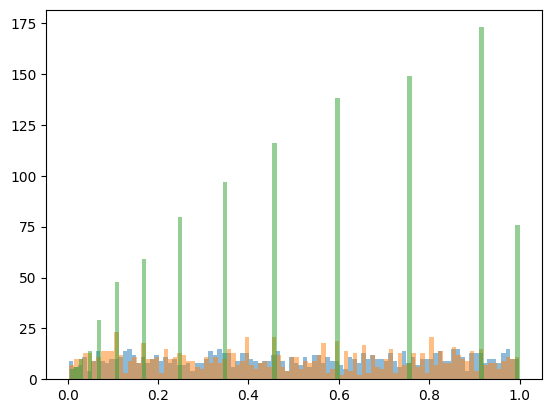

In [99]:
plt.hist(b_pos_p, bins=100, alpha=0.5, label='BEASTIE')
plt.hist(qb_pos_p, bins=100, alpha=0.5, label='qb')
plt.hist(ns_pos_p, bins=100, alpha=0.5, label='ns')
plt.show()

In [100]:
df = pd.merge(beastie_neg,qbeast_NEG,on="geneID")
df

,geneID,beastie_t_pval,qb_t_pval
0,gene1,0.593936,0.509021
1,gene2,0.347302,0.190687
2,gene3,0.450277,0.298794
3,gene4,0.782216,0.798139
4,gene5,0.464239,0.453398
...,...,...,...
995,gene996,0.463338,0.348257
996,gene997,0.155994,0.081311
997,gene998,0.984781,0.779647
998,gene999,0.742972,0.706993


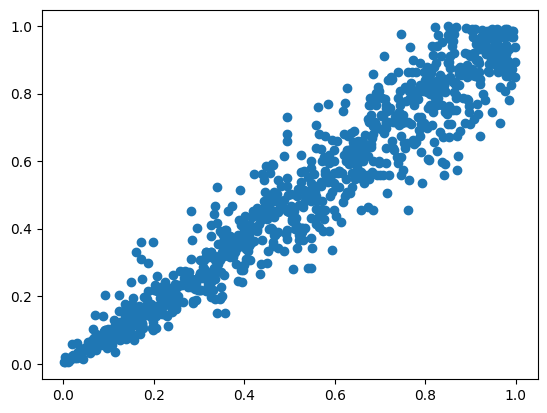

In [101]:
plt.scatter(beastie_neg["beastie_t_pval"],qbeast_NEG["qb_t_pval"])

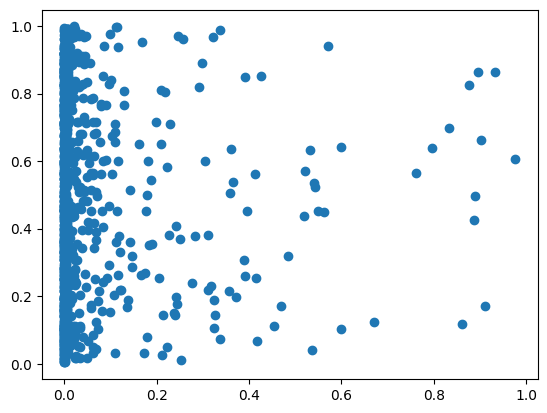

In [86]:
plt.scatter(b_neg_p,qb_neg_p)

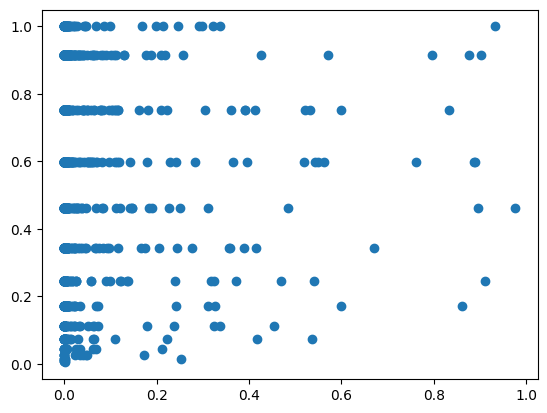

In [87]:
plt.scatter(b_neg_p,ns_neg_p)

### calculate power/type1error using p-values